# Contrastive Explanations Method(CEM) applied to Iris dataset

CEM generates instance based local black box explanations for classification models in terms of Pertinent Positives (PP) and Pertinent Negatives (PN). 

For a PP, the method finds the features that should be minimally and sufficiently present (e.g. important pixels in an image) to predict the same class as on the original instance. 

PN’s on the other hand identify what features should be minimally and necessarily absent from the instance to be explained in order to maintain the original prediction class. The aim of PN’s is not to provide a full set of characteristics that should be absent in the explained instance, but to provide a minimal set that differentiates it from the closest different class.

In [ ]:
!pip install alibi

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel(40)
tf.compat.v1.disable_v2_behavior() 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from alibi.explainers import CEM

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.3.0
Eager execution enabled:  False


Here, we have used the iris dataset:

In [ ]:
dataset = load_iris()
feature_names = dataset.feature_names
class_names = list(dataset.target_names)
class_names

['setosa', 'versicolor', 'virginica']

In [ ]:
dataset.data = (dataset.data - dataset.data.mean(axis=0)) / dataset.data.std(axis=0)

In [ ]:
idx = 145
x_train,y_train = dataset.data[:idx,:], dataset.target[:idx]
x_test, y_test = dataset.data[idx+1:,:], dataset.target[idx+1:]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Now, we are training our regression model:

In [ ]:
def lr_model():
    x_in = Input(shape=(4,))
    x_out = Dense(3, activation='softmax')(x_in)
    lr = Model(inputs=x_in, outputs=x_out)
    lr.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return lr

In [ ]:
lr = lr_model()
lr.summary()
lr.fit(x_train, y_train, batch_size=16, epochs=500, verbose=0)
lr.save('iris_lr.h5', save_format='h5')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


Generating contrastive explaination for pertinent negative:

In [ ]:
idx = 0
X = x_test[idx].reshape((1,) + x_test[idx].shape)
print('Prediction on instance to be explained: {}'.format(class_names[np.argmax(lr.predict(X))]))
print('Prediction probabilities for each class on the instance: {}'.format(lr.predict(X)))

Prediction on instance to be explained: virginica
Prediction probabilities for each class on the instance: [[2.3529849e-04 2.1037970e-01 7.8938496e-01]]


In [ ]:
mode = 'PN' 
shape = (1,) + x_train.shape[1:]  
kappa = .2 
            
            
beta = .1  
c_init = 10. 
c_steps = 10
max_iterations = 1000  
feature_range = (x_train.min(axis=0).reshape(shape)-.1,  
                 x_train.max(axis=0).reshape(shape)+.1)  
clip = (-1000.,1000.)  
lr_init = 1e-2  

Here, 

*   mode : 'PN' (Pertinent Negative) or 'PP' (Pertinent Positive)
*   shape : Shape of the current instance. As CEM is applicable for single explanations, we take 1.
*   kappa, beta, gamma, c_init, c_steps are all mathematical terms for calculating loss
*   max_iterations : the total no. of loss optimization steps for each value of c
*   feature_range : global or feature wise minimum and maximum values for the changed instance
*   clip : minimum and maximum gradient values
*   lr_init : initial learning rate 



In [ ]:
lr = load_model('iris_lr.h5')

# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
          learning_rate_init=lr_init, clip=clip)
cem.fit(x_train, no_info_type='median')  
explanation = cem.explain(X, verbose=False)

In [ ]:
print('Original instance: {}'.format(explanation.X))
print('Predicted class: {}'.format(class_names[explanation.X_pred]))
print('Pertinent negative: {}'.format(explanation.PN))
print('Predicted class: {}'.format(class_names[explanation.PN_pred]))

Original instance: [[ 0.55333328 -1.28296331  0.70592084  0.92230284]]
Predicted class: virginica
Pertinent negative: [[ 0.5533333 -1.2829633  0.7059208 -0.6580106]]
Predicted class: versicolor


In [ ]:
print('Pertinent negative: {}'.format(explanation.PN))
print('Predicted class: {}'.format(class_names[explanation.PN_pred]))

Pertinent negative: [[ 0.5533333  -1.2829633  -0.73568636  0.92230284]]
Predicted class: versicolor


The above result clearly shows that the pertinent negative method pushes the prediction to get a prediction different from the original prediction which is virginica to versicolor in this case.

The 3rd component in array which is petal length is different from the original one. Thus, it can be concluded that this change in petal length should necessarily be absent to retain the original prediction as virginica.

In [ ]:
expl = {}
expl['PN'] = explanation.PN
expl['PN_pred'] = explanation.PN_pred

Generating pertinent positive:

In [ ]:
mode = 'PP'

In [ ]:
# define model
lr = load_model('iris_lr.h5')

# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
          learning_rate_init=lr_init, clip=clip)
cem.fit(x_train, no_info_type='median')
explanation = cem.explain(X, verbose=False)

In [ ]:
print('Original instance: {}'.format(explanation.X))
print('Predicted class: {}'.format(class_names[explanation.X_pred]))
print('Pertinent positive: {}'.format(explanation.PP))
print('Predicted class: {}'.format(class_names[explanation.PP_pred]))

Original instance: [[ 0.55333328 -1.28296331  0.70592084  0.92230284]]
Predicted class: virginica
Pertinent positive: [[-7.44469730e-09 -3.47054341e-08  1.93995920e-01  8.99023372e-01]]
Predicted class: virginica


The above result shows the feature values that should be compulsorily and minimally present in order to get the same original class virginica as predicted class.

In [ ]:
expl['PP'] = explanation.PP
expl['PP_pred'] = explanation.PP_pred

Visualize PN and PP

In [ ]:
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['species'] = np.array([dataset.target_names[i] for i in dataset.target])

In [ ]:
pn = pd.DataFrame(expl['PN'], columns=dataset.feature_names)
pn['species'] = 'PN_' + class_names[expl['PN_pred']]
pp = pd.DataFrame(expl['PP'], columns=dataset.feature_names)
pp['species'] = 'PP_' + class_names[expl['PP_pred']]
orig_inst = pd.DataFrame(explanation.X, columns=dataset.feature_names)
orig_inst['species'] = 'orig_' + class_names[explanation.X_pred]
df = df.append([pn, pp, orig_inst], ignore_index=True)

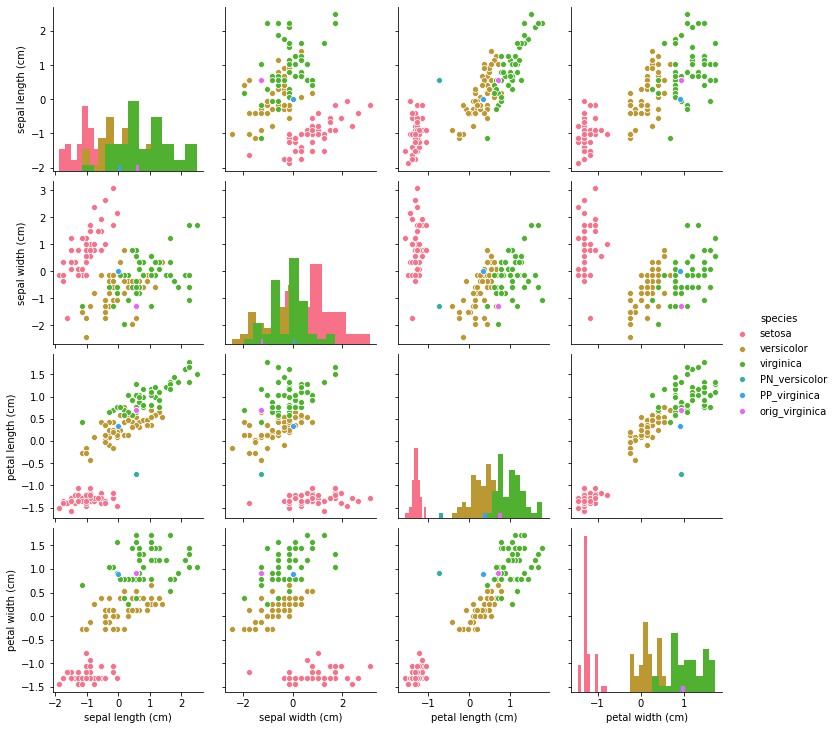

In [ ]:
fig = sns.pairplot(df, hue='species', diag_kind='hist',palette="husl");

The original prediction of the instance is shown in purple (label: orig_virginica). Now, when CEM with PN is applied, the instance is moved away from the mean of instances of virginica (original prediction) and when CEM with PP is applied, it is moved towards the mean of virginica. This is clearly shown in the above graphs as the blue dot showing PP-virginica is near the cluster of virginica(green dots) and the bluish green dot showing PN-versicolor is away from instances of virginica.

Thus, using CEM we can easily find out what features need to be minimally present and absent for the same class to be predicted. 